In [49]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from keras.utils import to_categorical
from collections import Counter
from PIL import Image
import glob
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

In [50]:


class SingleFolderDataGenerator(Sequence):
    def __init__(self, filepaths, labels, batch_size=32, target_size=(256, 256), shuffle=True):
        self.filepaths = filepaths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.samples = len(filepaths)  # Define the total number of samples in the dataset
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.samples / self.batch_size))

    def __getitem__(self, index):
        indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.filepaths[k] for k in indices]
        batch_labels = [self.labels[k] for k in indices]
        return self.__generate_data(batch_paths, batch_labels)

    def on_epoch_end(self):
        self.indexes = np.arange(self.samples)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __generate_data(self, batch_paths, batch_labels):
        images = []
        for path in batch_paths:
            img = load_img(path, target_size=self.target_size)
            img = img_to_array(img)
            img /= 255.0
            images.append(img)
        return np.array(images), np.array(batch_labels)

def create_generators(folder_path, batch_size=32, target_size=(256, 256), test_size=0.2, random_seed=42):
    filenames = os.listdir(folder_path)
    filepaths = [os.path.join(folder_path, f) for f in filenames]
    labels = [int(f.split('_')[0]) for f in filenames]

    # Split data into training and validation sets
    paths_train, paths_val, labels_train, labels_val = train_test_split(
        filepaths, labels, test_size=test_size, random_state=random_seed
    )

    train_gen = SingleFolderDataGenerator(paths_train, labels_train, batch_size=32, target_size=(256, 256))
    val_gen = SingleFolderDataGenerator(paths_val, labels_val, batch_size=10, target_size=(256, 256))

    return train_gen, val_gen

# Usage example
train_generator, validate_generator = create_generators('rokas_train', batch_size=32, target_size=(256, 256))

(32, 256, 256, 3) (32,)


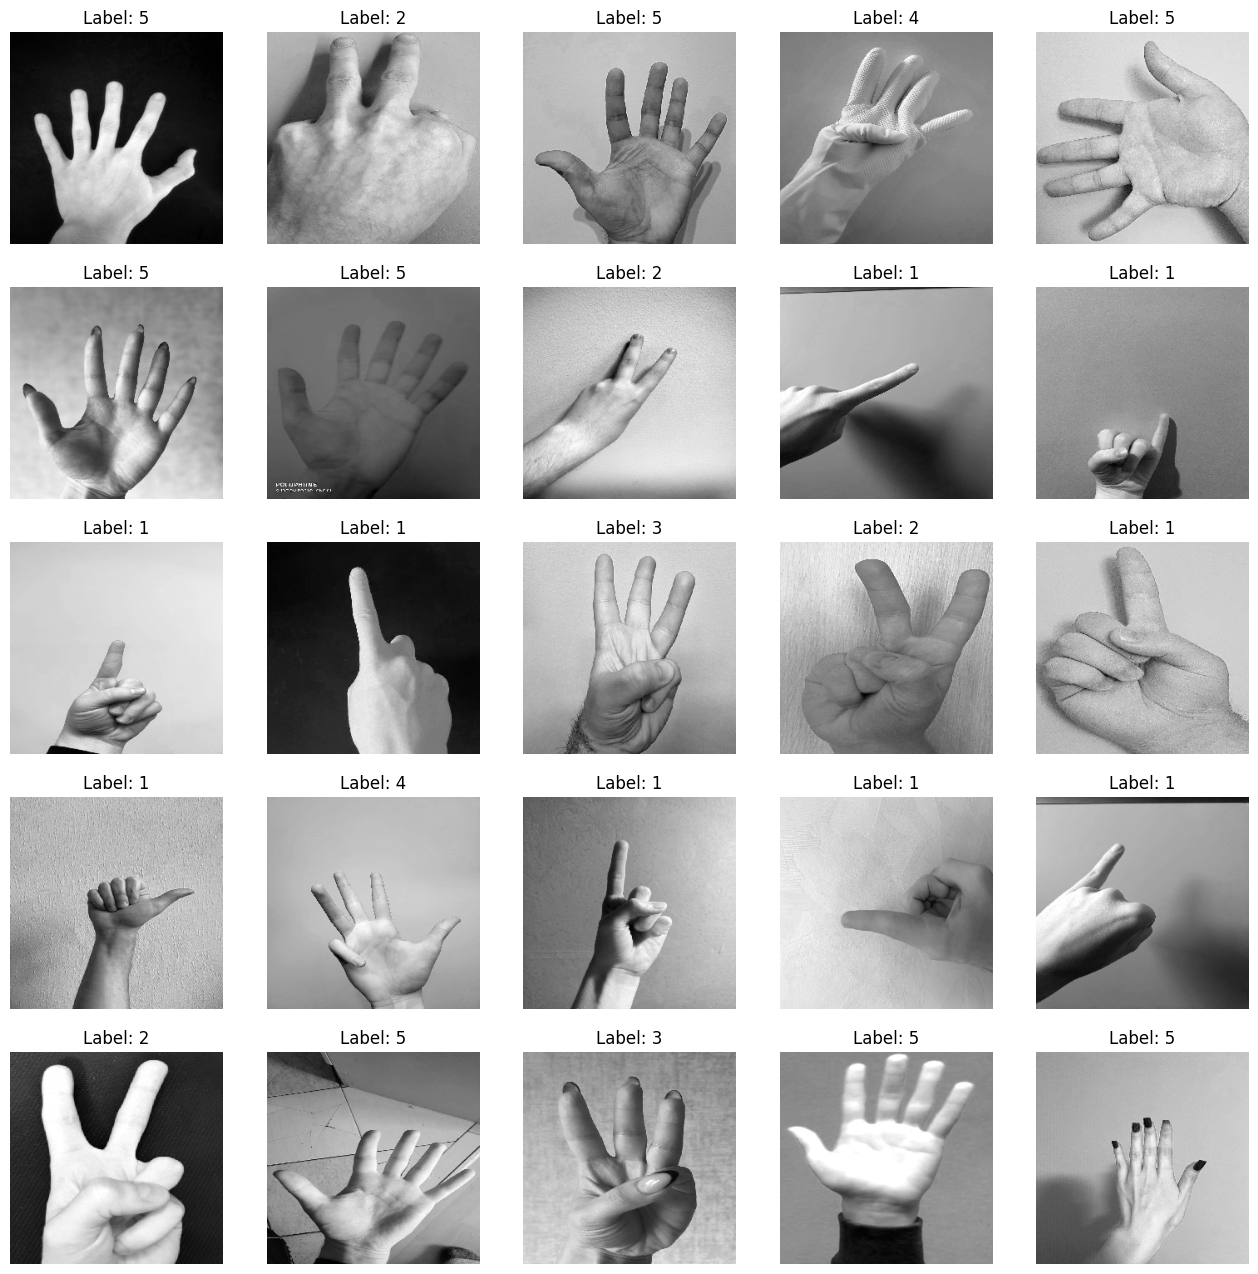

In [51]:
for X, y in train_generator:
    print(X.shape, y.shape)
    
    plt.figure(figsize=(16,16))
    for i in range(25):  # Ensure there are enough images in the batch to do this
        plt.subplot(5, 5, i + 1)
        plt.axis('off')
        plt.title(f'Label: {y[i]}')  # Direct use of label
        img = np.uint8(255 * X[i, :, :, 0])  # Assuming grayscale for visualization, adjust if RGB
        plt.imshow(img, cmap='gray')
    plt.show()  # Show the plot
    break

In [52]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,089,478 (49.93 MB)

 Trainable params: 13,089,478 (49.93 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=24,
    epochs=100,
    validation_data=validate_generator,
    validation_steps=5  
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.1941 - loss: 1.9817 - val_accuracy: 0.1600 - val_loss: 1.6225
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.1769 - loss: 1.6462 - val_accuracy: 0.3000 - val_loss: 1.6108
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.1933 - loss: 1.6209 - val_accuracy: 0.1667 - val_loss: 1.7057
Epoch 4/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.2719 - loss: 1.5698

AttributeError: 'NoneType' object has no attribute 'items'